# Pose Comparison with Body-part-level Pose Distance

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np
import pandas as pd
import math
import socket
import time

In [57]:
### Optional if you are using a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Model
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

### Load Video
video_path = '../../data/videos/'
# sampleVideo = video_path + 'sampleVideo.mp4'
# basicFour = video_path + 'basic_four.mp4'
# basicTwo = video_path + 'basic_two.mp4'
# swingDiff = video_path + 'swing_diff.mp4'
# swingSame = video_path + 'swing_same.mp4'
# swingRaw = video_path + 'swingRaw.mp4'
# temporalDifficult = video_path + 'temporalDifficultRaw.mp4'
# temporalEasy = video_path + 'temporalEasyRaw.mp4'
# practice1 = video_path + 'practice1.mp4'
# practice2 = video_path + 'practice2.mp4'
swingDiff_highQual = video_path + 'swingDiff_highQual.mp4'


# ### Draw EDGES
# EDGES = {
#     (0, 1): 'm',
#     (0, 2): 'c',
#     (1, 3): 'm',
#     (2, 4): 'c',
#     (0, 5): 'm',
#     (0, 6): 'c',
#     (5, 7): 'm',
#     (7, 9): 'm',
#     (6, 8): 'c',
#     (8, 10): 'c',
#     (5, 6): 'y',
#     (5, 11): 'm',
#     (6, 12): 'c',
#     (11, 12): 'y',
#     (11, 13): 'm',
#     (13, 15): 'm',
#     (12, 14): 'c',
#     (14, 16): 'c'
# }

### Draw NEW_EDGES
NEW_EDGES = {
#     (0, 1): 'm',
#     (0, 2): 'c',
#     (1, 3): 'm',
#     (2, 4): 'c',
#     (0, 5): 'm',
#     (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

### Vector List
vectorList = [
    [0,1],
    [0,2],
    [1,3],
    [2,4],
    [3,5],
    [0,6],
    [1,7],
    [6,7],
    [6,8],
    [7,9],
    [8,10],
    [9,11]
]


# # Function to convert range of variable (map fuction)
# def map_range(value, old_min, old_max, new_min, new_max):
#     # Calculate the percentage of the value within the original range
#     percentage = (value - old_min) / (old_max - old_min)
    
#     # Calculate the value within the new range using the percentage
#     new_value = (new_max - new_min) * percentage + new_min
    
#     # Return the new value
#     return new_value


# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold, BPD, confidence_level):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold, BPD, confidence_level)
        draw_keypoints(frame, person, confidence_threshold)


def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 3, (0,255,0), -1)

def draw_connections(frame, keypoints, edges, confidence_threshold, BPD, confidence_level):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
#     color_value_array = []
#     alpha_value_array = []
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
#         if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
#             cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
        index = list(edges.keys()).index(edge)
        color_value = np.interp(BPD[index], [0.0,1.0], [0.0,255.0])    # range of BPD with lambda = 1.0: [0,1]
        alpha_value = np.interp(confidence_level[index], [0.0,1.0], [0.0,255.0])    # range of averageConfidence: [0,1]

        
        cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255-color_value, color_value, alpha_value), 20)


###
# Variables for drawing plot in real-time


if __name__ == "__main__":
    ### Variables
    numberOfPeople = 2
    lambdaVal = 2.0
#     lamdaVal = 0.885

#     minBPD = 10.0
#     maxBPD = 0.0
    
#     saveNum = 0
#     saveBPD = []

    ### Loading Video File
    cap = cv2.VideoCapture(swingDiff_highQual)    ### Change the File Here!!
    while cap.isOpened():
        ret, frame = cap.read()

        
        ### Variables for each frame
        
        
        ### Resize image
        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
        input_img = tf.cast(img, dtype=tf.int32)
        
        
        ### Detection section
        results = movenet(input_img)
        keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
        keypoints_with_scores = keypoints_with_scores[:numberOfPeople]
#         keypoints_only = np.delete(keypoints_with_scores,2,2)    # remove confidence level
        keypoints_only_body = np.delete(keypoints_with_scores, [0,1,2,3,4], 1)   # raw keypoints value with confidence level
        
        
       ### Calculate normalized vector with average confidence level for each person
        norm_vectors_only_body = []
        for person in keypoints_only_body:
            tempPerson = []
            for i in vectorList:
                tempY = person[i[1]][0] - person[i[0]][0]
                tempX = person[i[1]][1] - person[i[0]][1]
                tempAverageS = (person[i[1]][2] + person[i[0]][2])/2
                tempVector = np.array([tempX, tempY])
                normalizedTempVector = tempVector / np.linalg.norm(tempVector)
                tempPerson.append([normalizedTempVector[0], normalizedTempVector[1], tempAverageS])
            norm_vectors_only_body.append(tempPerson)

        norm_vectors_only_body = np.array(norm_vectors_only_body)
        norm_vectors_only_body.reshape(2,12,3)
        
        
        ### Calculate d
        d = []
        confidence_level = []

        # loop for each body part
        for row in range(norm_vectors_only_body.shape[1]):    # body part(0~11)
            # Calculate confidence_level & build confidence_level array
            confidence_level.append(np.mean(norm_vectors_only_body[:,row,:], axis=0)[2])    # Get the confidence_level array

            # Calculate Vr (average value of each body part)
            Vr_avg_row = np.mean(norm_vectors_only_body[:,row,:], axis=0)[:2]    # (y,x)

            # Calculate Vj - Vr
            raw_Vj_Vr_subtract = norm_vectors_only_body[:,row,:2] - Vr_avg_row

            # Calculate |Vj - Vr| (norm)
            norm_Vj_Vr_substract = np.linalg.norm(raw_Vj_Vr_subtract, axis=1)

            # Calculate tempD value of body part (sum of norm_Vj_Vr_substract)
            tempD = np.sum(norm_Vj_Vr_substract)
            d.append(tempD)

            
        ### Calculate Body-part-level Pose Distance (BPD)
        BPD = np.power(np.array(d)/numberOfPeople,lambdaVal)
        print(BPD)
        print("============")
        
        

        # Render keypoints 
        loop_through_people(frame, keypoints_with_scores, NEW_EDGES, 0.1, BPD, confidence_level)
#         loop_through_people(frame, [keypoints_with_scores[0]], EDGES, 0.1)    # Check for first person.....
        
        # Print Lambda Value
        text_with_lambda = "Lambda Value: " + "{:.2f}".format(lambdaVal)
        font = cv2.FONT_HERSHEY_SIMPLEX
        location = (50, 50)
        cv2.putText(frame, text_with_lambda, location, font, 1, (0, 255, 0), 2)

                                                                                              
         # Show the frame
        cv2.imshow('Movenet Multipose', frame)
        
        # when press
        if cv2.waitKey(10) & 0xFF==ord('m'):
            lambdaVal += 0.1
        if cv2.waitKey(10) & 0xFF==ord('n'):
            lambdaVal -= 0.1
        
        if cv2.waitKey(10) & 0xFF==ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

[3.30436119e-03 1.67604387e-03 5.79292704e-06 5.21752438e-04
 2.09634547e-03 4.16563814e-05 7.95578424e-05 6.24193280e-04
 2.42577219e-05 1.05456645e-04 3.36978149e-05 1.34167227e-05]
[3.03665263e-03 1.45075594e-03 4.02345365e-07 7.74662201e-04
 2.11183582e-03 4.80763421e-05 1.09805934e-04 3.83672344e-04
 4.02655944e-05 6.10479058e-05 3.03985942e-05 4.16768717e-05]
[3.24869132e-03 1.33821878e-03 5.23048043e-06 6.80440244e-04
 2.28456027e-03 4.02749633e-05 9.49432318e-05 7.35610518e-04
 2.64170837e-05 1.08935576e-04 1.70574263e-05 2.75746292e-06]
[2.82788540e-03 1.24901736e-03 2.92178508e-05 7.23866478e-04
 2.41127016e-03 5.16048929e-08 1.06723469e-04 2.13456140e-04
 1.37081322e-04 9.67081129e-05 2.25041756e-05 1.37418934e-05]
[3.03056765e-03 9.90017224e-04 1.31501362e-05 6.07016640e-04
 2.24092996e-03 1.59826453e-05 1.24262926e-04 1.21488585e-04
 4.55524018e-05 1.01097557e-04 3.60348456e-05 5.18896234e-06]
[3.37324848e-03 1.73780044e-03 6.29678458e-05 3.38487186e-04
 2.78384719e-03 6.3

[8.69562358e-04 3.32665228e-04 1.92933994e-03 1.49872607e-07
 4.54603086e-03 4.61640994e-07 1.29370472e-04 9.64344832e-04
 2.87518863e-06 1.27314184e-05 1.82120252e-05 2.94568300e-04]
[1.61643478e-03 4.79486521e-06 1.39854683e-03 3.33197598e-06
 4.45684773e-03 6.13460845e-06 1.02858616e-04 5.98932049e-04
 7.44540524e-09 5.30647421e-06 3.56969612e-06 3.64370827e-04]
[1.53107129e-03 2.90219403e-04 1.19783620e-03 4.15451567e-05
 5.23248240e-03 2.15154877e-07 1.10888655e-04 2.40148544e-04
 2.19908246e-06 1.91975830e-06 3.06635065e-05 3.61716221e-04]
[2.59718738e-03 2.22357425e-05 1.54102092e-03 1.74036711e-04
 7.87929166e-03 1.74182453e-06 9.81931310e-05 7.70408353e-04
 1.28382523e-05 2.51847642e-06 6.44578476e-05 2.09987113e-04]
[2.27942679e-03 2.89813946e-04 3.60702054e-04 5.78770013e-06
 6.75895569e-03 1.28242644e-07 1.87082014e-04 5.36250774e-04
 2.70884596e-06 4.04507161e-06 4.04206232e-05 3.21678195e-04]
[2.16724891e-03 1.42047218e-04 3.06727872e-04 8.67383144e-05
 5.49322119e-03 9.6

[2.16790301e-01 9.99949874e-01 9.97448316e-01 9.52254547e-01
 4.36962953e-03 1.51755418e-05 5.74376048e-07 2.53361266e-03
 1.82974593e-05 1.00151819e-03 1.09359991e-04 3.38402918e-04]
[2.74352222e-01 9.95484958e-01 9.98403465e-01 2.87480564e-02
 9.28018932e-02 4.23413446e-04 9.21363178e-05 4.14857836e-01
 6.51999101e-04 1.40834161e-02 2.19482198e-04 5.89597262e-02]
[1.85779478e-01 9.85284794e-01 9.99461397e-01 5.98735801e-01
 8.68916702e-01 4.59689696e-05 5.64685354e-05 9.65692562e-01
 3.14524747e-02 1.91355035e-02 2.37301280e-02 1.52960768e-02]
[5.32347170e-02 1.17997373e-05 9.99771650e-01 9.93611073e-01
 8.12130834e-01 1.62454227e-03 6.04979303e-07 8.36994135e-01
 3.91041674e-04 2.63552778e-02 5.05327874e-04 7.56992196e-02]
[4.76056162e-02 3.58452524e-03 8.65996457e-01 9.53608107e-01
 9.00767324e-01 2.05200042e-03 2.69268193e-06 6.62232001e-01
 4.76284596e-02 3.12267104e-02 3.03944407e-02 2.15692135e-02]
[1.96229365e-02 8.13597868e-04 4.35035171e-03 5.15524798e-03
 6.02875693e-01 2.1

[2.97226409e-03 5.28999427e-02 1.21195438e-03 2.06966032e-02
 8.85061018e-04 3.92887236e-06 3.05198733e-04 1.09363922e-03
 5.04113500e-04 6.90958767e-04 1.77789686e-03 1.10915588e-06]
[5.51335023e-05 5.32852674e-02 1.13716672e-03 3.90265031e-02
 8.57633113e-04 1.17168637e-05 1.09078490e-04 3.32957408e-04
 2.08761989e-04 4.16988437e-05 1.73919478e-03 2.64372057e-05]
[9.97579468e-05 6.51307760e-02 2.29078943e-03 6.25146943e-02
 1.46762142e-03 8.88031762e-06 9.62383277e-05 7.13559074e-04
 1.31563404e-03 2.23155822e-05 7.01725231e-04 8.44674046e-07]
[9.70595836e-06 8.83927790e-02 5.60074180e-03 7.13270264e-02
 1.69388350e-03 2.93858061e-05 2.77723105e-05 9.97887330e-04
 9.49953885e-04 1.23103664e-05 6.73729872e-04 1.47815155e-05]
[1.59870266e-03 9.57505881e-02 4.95037628e-03 7.42776880e-02
 2.29157096e-03 1.90148769e-04 1.86526237e-06 3.91835207e-04
 7.47046410e-04 4.66774398e-05 4.66553007e-04 6.49950583e-05]
[0.0029362  0.12932692 0.00502138 0.07585138 0.00572862 0.00025244
 0.00014965 0

[1.24220172e-02 7.27247854e-03 5.70093444e-01 2.91688105e-02
 7.56180080e-02 2.96797564e-05 3.69741386e-05 8.42109192e-01
 3.24239335e-03 1.40926486e-04 1.46549483e-03 6.59531176e-04]
[7.51684309e-03 4.05778438e-03 6.37125315e-03 2.38050549e-02
 2.00787048e-05 5.08072006e-04 1.04521339e-05 4.18904801e-02
 8.57917584e-04 1.56405504e-06 2.26537277e-04 6.44049739e-04]
[5.27681302e-03 5.13018149e-03 7.49195460e-03 1.61299332e-02
 4.13827270e-02 7.38669224e-04 6.69588107e-05 1.19467383e-02
 3.81763114e-04 3.35883796e-06 3.73129390e-04 6.04247034e-04]
[1.02251628e-02 5.13232482e-03 5.51021263e-03 7.92822110e-03
 2.16138334e-02 1.85553188e-04 1.82687816e-04 7.87246533e-02
 1.16852794e-04 8.81649688e-05 3.25903849e-04 5.29883878e-04]
[9.42233856e-03 1.00677051e-02 7.44893443e-03 3.86219866e-02
 4.81137936e-02 5.37883346e-05 5.02206637e-05 1.12172033e-02
 2.92071135e-05 7.14472779e-05 1.00062090e-05 2.44231322e-04]
[6.48522594e-03 1.53502400e-02 4.46698724e-03 1.13261470e-03
 1.13732169e-02 7.4

[6.98209366e-04 3.98253295e-03 2.74419843e-05 5.49064773e-03
 3.36161509e-05 1.89862251e-07 6.35642815e-05 3.98884294e-03
 6.07989305e-07 3.98210269e-06 1.94060576e-04 2.88017295e-04]
[5.05754001e-04 2.02071928e-03 4.27864575e-05 4.07859640e-03
 4.48840317e-04 9.56399777e-06 1.36034660e-04 3.90990295e-03
 1.38840484e-07 3.23948313e-06 1.07961253e-04 4.66862066e-05]
[3.59680150e-03 1.54858004e-03 7.68199467e-05 2.73408633e-03
 3.16153713e-04 5.94287407e-07 8.40212755e-05 3.49163853e-05
 6.05661045e-07 4.02229920e-05 3.99585982e-05 5.25846666e-08]
[3.75377522e-03 2.17709503e-03 4.91918813e-05 1.66253828e-03
 7.11159441e-01 2.79160925e-04 6.18817970e-06 9.08476136e-05
 6.26121364e-05 2.34193940e-04 1.10585306e-04 1.65447245e-06]
[2.24896913e-03 1.98395162e-03 9.26260801e-01 9.97227929e-04
 6.73465040e-01 2.55199434e-04 4.77934620e-06 3.72973190e-04
 2.27868912e-05 3.09608234e-05 9.96246237e-05 1.21296197e-04]
[1.31348555e-03 1.70632172e-03 8.90602782e-01 8.09612498e-05
 5.51129173e-01 5.8

[1.71323297e-01 9.86640723e-01 7.19211081e-02 8.79768457e-02
 9.47968021e-01 2.52184522e-03 2.63775797e-04 2.97388437e-02
 7.38043067e-05 9.54943022e-04 4.79406322e-04 2.82959925e-04]
[1.88492773e-01 9.04300166e-01 1.81527972e-02 8.20371768e-02
 1.71785363e-01 2.34315637e-03 6.80592246e-04 1.02874874e-03
 3.89339279e-05 4.64198209e-04 2.23773247e-04 1.88708995e-04]
[1.31287002e-01 2.62227749e-03 3.09830529e-03 8.70357597e-01
 6.23533781e-02 1.64601625e-03 6.11140101e-04 5.18036332e-02
 2.60114764e-05 3.66617147e-05 7.48804629e-04 1.80998697e-04]
[2.77789645e-03 9.92594059e-01 1.51663706e-03 3.34989970e-01
 2.19937821e-03 2.70502756e-04 4.46397425e-04 3.42147763e-03
 5.25167077e-04 1.42808279e-05 4.79101231e-04 7.02927664e-05]
[6.72106386e-03 9.93869603e-01 2.66610362e-03 9.88511010e-01
 5.83404238e-04 1.12291365e-04 3.96951990e-05 2.60573091e-03
 3.83190949e-04 3.45960846e-04 4.02369823e-04 5.45855314e-07]
[5.75740880e-03 1.71873733e-05 2.10935963e-03 9.86778131e-01
 1.17707075e-03 3.2

[7.01854547e-03 8.84507717e-03 2.03783952e-01 1.86211783e-06
 6.67396373e-02 2.82994299e-05 5.51894074e-04 8.25853601e-01
 6.47333706e-03 4.21583967e-05 1.22213212e-04 5.99207308e-04]
[4.97957330e-03 2.52411823e-03 2.93293919e-01 3.47743704e-03
 1.03340496e-02 2.55908895e-05 2.90768441e-04 5.32566088e-01
 5.57805788e-03 2.89276929e-04 1.17694084e-06 3.76816258e-04]
[4.41743795e-03 3.02208068e-03 1.70798073e-01 3.58239616e-03
 2.36195174e-02 1.87245312e-06 2.94400249e-04 5.18240160e-01
 4.31290027e-03 6.45152631e-04 1.32378092e-04 3.84321654e-04]
[6.14555400e-03 3.34097561e-04 2.43387541e-01 6.99396894e-01
 2.58255616e-02 1.08994114e-04 6.87659332e-04 7.77630751e-01
 4.26484747e-03 3.48401861e-04 7.92438559e-08 4.79836125e-04]
[3.76956227e-03 2.04257572e-03 1.89845042e-01 5.43682914e-01
 1.48377770e-01 3.04358545e-05 8.92975198e-04 8.88187527e-01
 3.56791694e-03 9.89958203e-05 1.84428773e-04 1.06421770e-03]
[9.07952639e-04 2.11913379e-03 3.74121842e-01 1.59384187e-03
 2.01487188e-01 4.7

[2.37890871e-03 2.51510024e-03 5.08410468e-03 3.38812169e-03
 8.64016646e-03 9.19963642e-06 3.20432436e-05 4.51976444e-03
 6.91758367e-07 1.84885100e-05 1.52956758e-05 1.80796927e-04]
[1.41832688e-03 1.32508453e-03 1.60895199e-03 6.12796795e-03
 1.09513744e-02 1.23213319e-05 5.19201000e-06 4.85038779e-03
 1.57512859e-05 3.73741475e-07 7.43063155e-05 2.18770572e-04]
[5.96139368e-04 2.17104169e-03 3.90250455e-03 5.50288128e-03
 1.11028204e-02 1.41222683e-05 1.78390616e-08 3.92795658e-03
 1.13535486e-06 4.01921043e-06 8.34972622e-06 2.73664417e-04]
[1.36725239e-03 3.38376313e-03 7.47018497e-04 8.46994231e-03
 1.31254069e-02 6.68371312e-05 1.76595728e-04 3.41677786e-03
 1.54232282e-05 8.87823139e-07 5.41114265e-06 3.03130050e-05]
[1.54361475e-03 7.04047237e-03 5.77495142e-03 5.24378241e-03
 4.02668146e-03 9.37738934e-05 2.73066997e-04 2.21376513e-03
 8.40694849e-05 1.46301444e-05 6.66329791e-06 5.30776850e-05]
[1.66104777e-03 3.12439400e-03 9.27016391e-04 4.80714931e-03
 6.57883375e-03 1.8

[4.51849514e-04 5.53712710e-03 1.40999244e-04 7.20211801e-04
 3.63628655e-03 1.33257992e-04 6.19168752e-05 9.53197338e-05
 1.66053429e-03 1.93986911e-05 2.44078079e-03 6.20076873e-06]
[2.14202039e-04 9.39918551e-03 2.29823250e-06 3.25311818e-04
 4.25631004e-03 1.84303857e-04 6.32697362e-06 4.66365845e-05
 1.50772176e-03 3.50457941e-06 2.83078321e-03 8.38669407e-06]
[1.83751780e-04 1.11417043e-02 1.29073754e-04 5.22850780e-04
 3.13112677e-03 2.92557037e-04 4.35369662e-05 8.73652380e-05
 1.37339808e-03 5.60636177e-05 2.92962627e-03 3.76153071e-05]
[4.47887996e-04 1.48983621e-02 2.74498960e-03 1.08011092e-04
 2.58304202e-03 4.86989725e-04 2.56409134e-05 1.68973916e-04
 1.19796927e-03 1.18514425e-04 3.01799668e-03 2.66884244e-05]
[6.36949691e-04 1.58346726e-02 3.39999394e-03 1.12440688e-04
 2.09248435e-03 4.52019612e-04 5.06814933e-05 3.33199409e-05
 9.87463526e-04 1.50918300e-04 3.27843125e-03 3.61238206e-05]
[7.19598259e-04 1.18489477e-02 3.56132547e-03 1.19784620e-05
 9.63404722e-04 3.6

AttributeError: 'NoneType' object has no attribute 'copy'

In [6]:
norm_vectors_only_body

array([[[-0.8697291 , -0.49352935,  0.80376363],
        [-0.01638335,  0.99986583,  0.80911815],
        [ 0.05930027,  0.99824017,  0.49431974],
        [ 0.12142585,  0.9926005 ,  0.5886929 ],
        [-0.06597925,  0.99782097,  0.29004645],
        [-0.02449761,  0.99969983,  0.89529264],
        [ 0.02174361,  0.99976361,  0.8042587 ],
        [-0.99751979, -0.07038691,  0.89578772],
        [ 0.13833863,  0.990385  ,  0.73797679],
        [ 0.02613729,  0.99965841,  0.90394342],
        [ 0.46543747,  0.88508075,  0.6404497 ],
        [ 0.08270106,  0.9965744 ,  0.82501745]],

       [[-0.81517833, -0.57920998,  0.75862533],
        [ 0.11468346,  0.99340206,  0.72618538],
        [ 0.00600761,  0.99998194,  0.41817448],
        [ 0.18011065,  0.98364639,  0.64947152],
        [-0.09422541,  0.99555081,  0.14723212],
        [-0.00865183,  0.99996257,  0.88765305],
        [ 0.01603092,  0.99987149,  0.77246886],
        [-0.99374181, -0.11170158,  0.90149659],
        [ 0.202347

In [8]:
### Calculate d

d = []
confidence_level = []


# loop for each body part
for row in range(norm_vectors_only_body.shape[1]):    # body part(0~11)
    # Calculate confidence_level & build confidence_level array
    confidence_level.append(np.mean(norm_vectors_only_body[:,row,:], axis=0)[2])    # Get the confidence_level array
    
    # Calculate Vr (average value of each body part)
    Vr_avg_row = np.mean(norm_vectors_only_body[:,row,:], axis=0)[:2]    # (y,x)
    
    # Calculate Vj - Vr
    raw_Vj_Vr_subtract = norm_vectors_only_body[:,row,:2] - Vr_avg_row
    
    # Calculate |Vj - Vr| (norm)
    norm_Vj_Vr_substract = np.linalg.norm(raw_Vj_Vr_subtract, axis=1)
    
    # Calculate tempD value of body part (sum of norm_Vj_Vr_substract)
    tempD = np.sum(norm_Vj_Vr_substract)
    d.append(tempD)

print(d)

### Calculate Body-part-level Pose Distance (BPD)
BPD = np.power(np.array(d)/numberOfPeople,lambdaVal)
print(BPD)

[0.1015724233234104, 3.5480096735965247, 3.53583466513402, 3.640168912537869, 3.425394260902789, 3.4893855865078605, 3.5235106020968585, 0.9421679735181471, 3.656239475496192, 3.549964710684423, 3.857586429292925, 3.5812965055916255]
[0.05078621 1.77400484 1.76791733 1.82008446 1.71269713 1.74469279
 1.7617553  0.47108399 1.82811974 1.77498236 1.92879321 1.79064825]


In [26]:
norm_vectors_only_body[:,0,:][1][:2]

array([-0.81517833, -0.57920998])

In [23]:
norm = np.linalg.norm(norm_vectors_only_body[:,0,:][1][:2])
print(norm)

0.9999999610982001


In [12]:
norm_vectors_only_body[:,0,:]

array([[-0.99941862,  0.03409468,  0.90827596],
       [-0.99815601, -0.06069986,  0.92515367]])

In [15]:
norm_vectors_only_body[:,0,:2]

array([[-0.99941862,  0.03409468],
       [-0.99815601, -0.06069986]])

In [14]:
norm_vectors_only_body[:,row,:][:2]

array([[0.08270106, 0.9965744 , 0.82501745],
       [0.08085329, 0.99672598, 0.83367884]])

In [28]:
# Calculate Vr (average value of each body part)
Vr_avg_row = np.mean(norm_vectors_only_body[:,row,:], axis=0)[:2]
Vr_avg_row

array([0.08177718, 0.99665019])

In [32]:
norm_vectors_only_body[:,row,:2]

array([[0.08270106, 0.9965744 ],
       [0.08085329, 0.99672598]])

In [33]:
# Calculate Vj - Vr
raw_Vj_Vr_subtract = norm_vectors_only_body[:,row,:2] - Vr_avg_row
raw_Vj_Vr_subtract

array([[ 9.23886895e-04, -7.57873058e-05],
       [-9.23886895e-04,  7.57873058e-05]])

In [34]:
# Calculate |Vj - Vr| (norm)
norm_Vj_Vr_substract = np.linalg.norm(raw_Vj_Vr_subtract, axis=1)
norm_Vj_Vr_substract

array([0.00092699, 0.00092699])

In [12]:
# Calculate tempD value of body part (sum of norm_Vj_Vr_substract)
tempD = np.sum(norm_Vj_Vr_substract)
tempD

3.5812965055916255

In [14]:
import numpy as np

# original array
arr = np.array([[-0.99941862, 0.03409468, 0.90827596],
                [-0.99815601, -0.06069986, 0.92515367]])

# take the mean along axis 0 and reshape the result
avg_arr = np.mean(arr, axis=0)[:2]

print(avg_arr)

[-0.99878731 -0.01330259]


In [16]:
import numpy as np

arr = np.array([[1, 1], [2, 2]])
sub_arr = np.array([1, 1])
result = arr - sub_arr

print(result)

[[0 0]
 [1 1]]


In [24]:
sub_arr = np.array([2, 2])
sub_arr / 2

array([1., 1.])

In [25]:
import numpy as np

a = np.array([1.0, 4.0, 9.0])
b = np.power(a, 0.5)

print(b)

[1. 2. 3.]


In [26]:
import numpy as np

vectors = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

average_vector = np.mean(vectors, axis=0)

print(average_vector)  # Output: [4. 5. 6.]

[4. 5. 6.]


In [20]:
import numpy as np

vector = np.array([1, 1])
norm = np.linalg.norm(vector)
print(norm)

1.4142135623730951


In [36]:
a = map_range(2,0,1,0,10)
a

20.0

In [37]:
import numpy as np

# define input value
input_value = 0.5

# define input range
input_min = 0
input_max = 1

# define output range
output_min = 0
output_max = 255

# scale input value to output range
output_value = np.interp(input_value, [input_min, input_max], [output_min, output_max])

print(output_value)  # output: 127.5

127.5


In [41]:
output_value = np.interp(-1, [0, 1], [0, 10])
print(output_value)  # output: 127.5

0.0


# Saving pandas dataframe as CSV & Drawing plots

In [59]:
from matplotlib import pyplot as plt
from matplotlib import animation
import pandas as pd

In [ ]:
csv_path = '../../data/csv/'
csv_name = 'BPDtest.csv'
with open(csv_path + csv_name, mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)

In [73]:
### Optional if you are using a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Load Model
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

### Load Video
video_path = '../../data/videos/'
# sampleVideo = video_path + 'sampleVideo.mp4'
# basicFour = video_path + 'basic_four.mp4'
# basicTwo = video_path + 'basic_two.mp4'
# swingDiff = video_path + 'swing_diff.mp4'
# swingSame = video_path + 'swing_same.mp4'
# swingRaw = video_path + 'swingRaw.mp4'
# temporalDifficult = video_path + 'temporalDifficultRaw.mp4'
# temporalEasy = video_path + 'temporalEasyRaw.mp4'
# practice1 = video_path + 'practice1.mp4'
# practice2 = video_path + 'practice2.mp4'
swingDiff_highQual = video_path + 'swingDiff_highQual.mp4'


# ### Draw EDGES
# EDGES = {
#     (0, 1): 'm',
#     (0, 2): 'c',
#     (1, 3): 'm',
#     (2, 4): 'c',
#     (0, 5): 'm',
#     (0, 6): 'c',
#     (5, 7): 'm',
#     (7, 9): 'm',
#     (6, 8): 'c',
#     (8, 10): 'c',
#     (5, 6): 'y',
#     (5, 11): 'm',
#     (6, 12): 'c',
#     (11, 12): 'y',
#     (11, 13): 'm',
#     (13, 15): 'm',
#     (12, 14): 'c',
#     (14, 16): 'c'
# }

### Draw NEW_EDGES
NEW_EDGES = {
#     (0, 1): 'm',
#     (0, 2): 'c',
#     (1, 3): 'm',
#     (2, 4): 'c',
#     (0, 5): 'm',
#     (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

### Vector List
vectorList = [
    [0,1],
    [0,2],
    [1,3],
    [2,4],
    [3,5],
    [0,6],
    [1,7],
    [6,7],
    [6,8],
    [7,9],
    [8,10],
    [9,11]
]


# # Function to convert range of variable (map fuction)
# def map_range(value, old_min, old_max, new_min, new_max):
#     # Calculate the percentage of the value within the original range
#     percentage = (value - old_min) / (old_max - old_min)
    
#     # Calculate the value within the new range using the percentage
#     new_value = (new_max - new_min) * percentage + new_min
    
#     # Return the new value
#     return new_value


# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold, BPD, confidence_level):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold, BPD, confidence_level)
        draw_keypoints(frame, person, confidence_threshold)


def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 3, (0,255,0), -1)

def draw_connections(frame, keypoints, edges, confidence_threshold, BPD, confidence_level):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
#     color_value_array = []
#     alpha_value_array = []
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
#         if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
#             cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
        index = list(edges.keys()).index(edge)
        color_value = np.interp(BPD[index], [0.0,1.0], [0.0,255.0])    # range of BPD with lambda = 1.0: [0,1]
        alpha_value = np.interp(confidence_level[index], [0.0,1.0], [0.0,255.0])    # range of averageConfidence: [0,1]

        
        cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255-color_value, color_value, alpha_value), 20)


###
# Variables for drawing plot in real-time


if __name__ == "__main__":
    ### Variables
    numberOfPeople = 2
    lambdaVal = 1.0
#     lamdaVal = 0.885

#     minBPD = 10.0
#     maxBPD = 0.0
    
#     saveNum = 0
#     saveBPD = []
    saveBPD = pd.DataFrame(columns=[str(i) for i in range(12)])

    ### Loading Video File
    cap = cv2.VideoCapture(swingDiff_highQual)    ### Change the File Here!!
    while cap.isOpened():
        ret, frame = cap.read()

        
        ### Variables for each frame
        
        
        ### Resize image
        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
        input_img = tf.cast(img, dtype=tf.int32)
        
        
        ### Detection section
        results = movenet(input_img)
        keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
        keypoints_with_scores = keypoints_with_scores[:numberOfPeople]
#         keypoints_only = np.delete(keypoints_with_scores,2,2)    # remove confidence level
        keypoints_only_body = np.delete(keypoints_with_scores, [0,1,2,3,4], 1)   # raw keypoints value with confidence level
        
        
       ### Calculate normalized vector with average confidence level for each person
        norm_vectors_only_body = []
        for person in keypoints_only_body:
            tempPerson = []
            for i in vectorList:
                tempY = person[i[1]][0] - person[i[0]][0]
                tempX = person[i[1]][1] - person[i[0]][1]
                tempAverageS = (person[i[1]][2] + person[i[0]][2])/2
                tempVector = np.array([tempX, tempY])
                normalizedTempVector = tempVector / np.linalg.norm(tempVector)
                tempPerson.append([normalizedTempVector[0], normalizedTempVector[1], tempAverageS])
            norm_vectors_only_body.append(tempPerson)

        norm_vectors_only_body = np.array(norm_vectors_only_body)
        norm_vectors_only_body.reshape(2,12,3)
        
        
        ### Calculate d
        d = []
        confidence_level = []

        # loop for each body part
        for row in range(norm_vectors_only_body.shape[1]):    # body part(0~11)
            # Calculate confidence_level & build confidence_level array
            confidence_level.append(np.mean(norm_vectors_only_body[:,row,:], axis=0)[2])    # Get the confidence_level array

            # Calculate Vr (average value of each body part)
            Vr_avg_row = np.mean(norm_vectors_only_body[:,row,:], axis=0)[:2]    # (y,x)

            # Calculate Vj - Vr
            raw_Vj_Vr_subtract = norm_vectors_only_body[:,row,:2] - Vr_avg_row

            # Calculate |Vj - Vr| (norm)
            norm_Vj_Vr_substract = np.linalg.norm(raw_Vj_Vr_subtract, axis=1)

            # Calculate tempD value of body part (sum of norm_Vj_Vr_substract)
            tempD = np.sum(norm_Vj_Vr_substract)
            d.append(tempD)

            
        ### Calculate Body-part-level Pose Distance (BPD)
        BPD = np.power(np.array(d)/numberOfPeople,lambdaVal)
        print(BPD)
        print("============")
        
        ### Save each BPD at the saveBPD for CSV saving
        saveBPD = pd.concat([saveBPD, pd.DataFrame([BPD], columns=saveBPD.columns)], ignore_index=True)

        # Render keypoints 
        loop_through_people(frame, keypoints_with_scores, NEW_EDGES, 0.1, BPD, confidence_level)
#         loop_through_people(frame, [keypoints_with_scores[0]], EDGES, 0.1)    # Check for first person.....
        
        # Print Lambda Value
        text_with_lambda = "Lambda Value: " + "{:.2f}".format(lambdaVal)
        font = cv2.FONT_HERSHEY_SIMPLEX
        location = (50, 50)
        cv2.putText(frame, text_with_lambda, location, font, 1, (0, 255, 0), 2)

                                                                                              
         # Show the frame
        cv2.imshow('Movenet Multipose', frame)
        
        # when press
        if cv2.waitKey(10) & 0xFF==ord('m'):
            lambdaVal += 0.1
        if cv2.waitKey(10) & 0xFF==ord('n'):
            lambdaVal -= 0.1
        
        if cv2.waitKey(10) & 0xFF==ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

[0.05748357 0.04093951 0.00240685 0.0228419  0.04578587 0.00645418
 0.00891952 0.02498386 0.00492521 0.01026921 0.00580498 0.00366288]
[0.05510583 0.03808879 0.00063431 0.02783275 0.04595471 0.00693371
 0.01047883 0.01958756 0.00634552 0.00781332 0.00551349 0.00645576]
[0.05699729 0.03658167 0.00228702 0.02608525 0.04779707 0.00634626
 0.00974388 0.02712214 0.00513976 0.01043722 0.00413006 0.00166056]
[0.05317787 0.03534144 0.00540535 0.02690477 0.04910469 0.00022717
 0.01033071 0.01461014 0.01170817 0.00983403 0.00474386 0.00370701]
[0.05505059 0.03146454 0.00362631 0.02463771 0.04733846 0.00399783
 0.01114733 0.01102219 0.00674925 0.01005473 0.0060029  0.00227793]
[0.05807967 0.04168693 0.00793523 0.01839802 0.05276218 0.00079386
 0.01052365 0.01564517 0.00564648 0.00915902 0.00529096 0.00451389]
[0.04878452 0.03563886 0.02268529 0.02139089 0.05487013 0.00284475
 0.0091227  0.01304753 0.00436712 0.00906758 0.00483098 0.00413742]
[0.05540961 0.04222558 0.01017574 0.02434255 0.05391952

[0.05155038 0.04302041 0.01567054 0.01250937 0.0970628  0.00087955
 0.0080728  0.05046248 0.00832034 0.00272243 0.00602519 0.02447319]
[0.03998739 0.03061293 0.01576797 0.00142939 0.10794627 0.0023168
 0.00569103 0.04116345 0.01047761 0.00286901 0.00409903 0.02171925]
[0.04808535 0.06834453 0.02413867 0.02064619 0.1315336  0.00313274
 0.00302106 0.05863331 0.00740443 0.00423093 0.00353974 0.02355087]
[0.05036292 0.08223146 0.00314633 0.00655588 0.13394936 0.0020012
 0.00278384 0.05640141 0.01693886 0.00387431 0.00016327 0.02001102]
[0.04255666 0.0804391  0.01715776 0.01681802 0.1264979  0.00046608
 0.00111988 0.05539388 0.01764262 0.00553341 0.00836359 0.02053077]
[0.00580004 0.07959224 0.01376572 0.02357495 0.12567068 0.00066991
 0.00834278 0.04375322 0.01086023 0.00539692 0.00783436 0.01883914]
[0.00552377 0.06533553 0.0060851  0.02473452 0.14791422 0.00190918
 0.00506176 0.04732462 0.00876667 0.01079473 0.01004574 0.01367898]
[0.00068394 0.09060794 0.01107093 0.00137005 0.11466816 0

[0.00166166 0.9714011  0.2097842  0.14791125 0.43994635 0.01768949
 0.01279382 0.67944896 0.02565175 0.01357936 0.04636632 0.01742126]
[0.04791908 0.96959135 0.21205497 0.08226481 0.07033323 0.00672191
 0.00365918 0.8486461  0.03681734 0.03020488 0.04100387 0.03254279]
[0.01514227 0.96150477 0.1978343  0.10013221 0.08258387 0.01439091
 0.00408427 0.84039139 0.03065471 0.01952864 0.03632681 0.01899894]
[0.03578848 0.961751   0.14067754 0.18403111 0.08269622 0.00893983
 0.00979467 0.90033751 0.02837096 0.01437736 0.03860439 0.01162752]
[0.04553878 0.96897336 0.13068246 0.06286302 0.04656779 0.02271755
 0.00470599 0.89982328 0.03010015 0.00751311 0.03718979 0.01047555]
[0.01868372 0.96783352 0.10413808 0.00335993 0.51381548 0.00533794
 0.00914801 0.90105233 0.02292977 0.01401986 0.03981567 0.00688655]
[0.00914343 0.97596159 0.0798495  0.01949972 0.03304695 0.02106855
 0.00200948 0.76074576 0.01405602 0.009381   0.04355206 0.00465733]
[2.01020111e-04 9.96098748e-01 6.64269077e-02 9.8019201

[0.04872183 0.21115094 0.88780086 0.81263006 0.66359669 0.02287433
 0.02745027 0.92325767 0.07225319 0.04166229 0.0055292  0.01958758]
[0.01464813 0.20315596 0.56954998 0.21674125 0.27645969 0.03218256
 0.01171954 0.36696026 0.04125592 0.00723219 0.00593534 0.01537754]
[0.0295667  0.15788799 0.07119825 0.1955369  0.03691034 0.01485853
 0.00221871 0.18421443 0.04206645 0.00953043 0.01062425 0.02183663]
[0.05068894 0.15714085 0.60092826 0.99619781 0.05019678 0.00251677
 0.00135572 0.20922052 0.0540999  0.00572755 0.02300208 0.02129782]
[0.0759048  0.11022726 0.05471137 0.16211579 0.01247608 0.00181767
 0.00425556 0.00756608 0.04145946 0.00879287 0.02776518 0.02061789]
[0.1114541  0.08527883 0.75504533 0.17078879 0.27498729 0.00544791
 0.00608064 0.91766508 0.05694202 0.01187125 0.03828178 0.02568134]
[0.08669973 0.06370074 0.07982013 0.15428887 0.00448093 0.02254045
 0.00323298 0.20467164 0.02929023 0.00125062 0.01505116 0.02537814]
[0.07264168 0.07162529 0.08655608 0.12700367 0.20342745

[0.09757835 0.10068144 0.02793215 0.87732999 0.17321212 0.00938951
 0.00332251 0.05882371 0.01425463 0.00538787 0.0113261  0.00155425]
[0.27305671 0.04231871 0.02442902 0.02159768 0.2502057  0.00502249
 0.00939478 0.01387775 0.01571496 0.00740036 0.02027579 0.01847904]
[0.25796511 0.04872545 0.04665728 0.12833821 0.38322205 0.00630928
 0.01174352 0.00911405 0.02025096 0.0116161  0.01861501 0.00628954]
[0.18233184 0.01513158 0.99642829 0.04087382 0.09791796 0.0113438
 0.0069339  0.06206205 0.01428999 0.01132453 0.01797453 0.00214564]
[0.03732134 0.99650517 0.99986948 0.92049577 0.73031795 0.0107029
 0.01041373 0.05706405 0.02489092 0.02426051 0.00711811 0.01248873]
[0.21999442 0.99872279 0.99810014 0.95074209 0.49362439 0.01483905
 0.0064584  0.16425583 0.02404454 0.0170967  0.00985961 0.002453  ]
[0.87619072 0.05637118 0.08155562 0.99798994 0.9995136  0.04184554
 0.01847014 0.04173869 0.00466012 0.01346057 0.01269759 0.01556526]
[0.09715183 0.01914459 0.02596695 0.06532784 0.09427175 0

[0.0302434  0.01071478 0.06649536 0.09581368 0.0378317  0.00286339
 0.00523895 0.0552898  0.00670887 0.0112632  0.01444021 0.01277101]
[0.01222919 0.01019814 0.03271512 0.01394006 0.01631768 0.00370281
 0.00098703 0.05691248 0.00958996 0.0068758  0.03687356 0.01151371]
[0.00850336 0.03359678 0.06033021 0.01266797 0.00741511 0.00111817
 0.00251923 0.05375864 0.00091566 0.00072755 0.03068964 0.00707695]
[0.02159352 0.02743198 0.0560494  0.00551102 0.02056401 0.0052142
 0.00520077 0.05281976 0.00907177 0.00229945 0.03508648 0.01494035]
[0.00782578 0.01572396 0.0147344  0.03088278 0.01245835 0.01286125
 0.00527964 0.09954899 0.01148927 0.00639183 0.03181102 0.0071364 ]
[0.05576702 0.00330875 0.00429569 0.01193275 0.01820638 0.02166319
 0.00689144 0.08089807 0.01459912 0.00280375 0.03731744 0.00513202]
[7.69587039e-02 2.71010736e-02 7.00232037e-04 8.57612938e-03
 9.14384722e-01 2.00875194e-02 6.89737202e-03 5.12660284e-02
 2.24614948e-02 4.61291159e-03 3.15467782e-02 1.04653487e-02]
[0.0397

[0.0425215  0.02809388 0.03500505 0.92239446 0.01136783 0.00095462
 0.01972426 0.00269213 0.0021807  0.03139208 0.02620872 0.03091052]
[0.02251753 0.04941072 0.06352418 0.9045034  0.00095335 0.0055368
 0.0142543  0.01385251 0.00879446 0.02156526 0.02490117 0.03760654]
[2.86161859e-03 1.89085287e-02 5.05428512e-02 9.31899883e-01
 7.87624029e-03 3.72659190e-03 7.77856375e-04 7.79494271e-03
 1.11484301e-02 1.82369818e-02 2.67134084e-02 3.54965018e-02]
[0.00751161 0.01246854 0.06545355 0.0554811  0.01213206 0.00976952
 0.00030217 0.05181691 0.01210667 0.0154526  0.02844877 0.03367   ]
[0.02316102 0.00536022 0.04968541 0.04433655 0.04148731 0.00774363
 0.00919329 0.05617195 0.01316382 0.01002214 0.03000966 0.02676704]
[3.39176135e-02 4.27855195e-03 4.05081630e-02 9.99966866e-01
 3.92573590e-02 8.16864211e-04 7.84011000e-03 5.17310455e-02
 2.14497410e-02 8.92589557e-03 3.62919393e-02 2.63216843e-02]
[2.97811406e-02 1.81947962e-03 5.81812916e-02 5.10593327e-02
 3.27086924e-02 1.34409129e-05 2

[0.02125675 0.07441187 0.01187431 0.02683676 0.06030163 0.01154374
 0.00786873 0.00976318 0.04074965 0.00440439 0.04940426 0.00249013]
[0.01463564 0.0969494  0.00151599 0.0180364  0.0652404  0.01357586
 0.00251535 0.0068291  0.03882939 0.00187205 0.05320511 0.00289598]
[0.01355551 0.10555427 0.01136106 0.02286593 0.05595647 0.0171043
 0.00659825 0.00934694 0.03705939 0.00748756 0.05412602 0.00613313]
[0.02116336 0.12205885 0.05239265 0.01039284 0.05082364 0.02206784
 0.00506369 0.012999   0.03461169 0.01088643 0.0549363  0.00516608]
[0.02523786 0.1258359  0.05830947 0.01060381 0.04574368 0.02126075
 0.00711909 0.00577234 0.03142393 0.01228488 0.05725759 0.00601031]
[0.02682533 0.10885287 0.05967684 0.00346099 0.03103876 0.01922515
 0.00529508 0.00400587 0.03039935 0.01232199 0.05557833 0.00799856]
[0.03604593 0.09019284 0.0576425  0.01441737 0.03166303 0.01641315
 0.00692274 0.00216667 0.02871125 0.01133617 0.05427603 0.01257922]
[0.02646892 0.13077291 0.07777261 0.02456031 0.03345507 

AttributeError: 'NoneType' object has no attribute 'copy'

In [76]:
saveBPD.tail()

,0,1,2,3,4,5,6,7,8,9,10,11
398,0.001825,0.085201,0.062812,0.001152,0.026334,0.013211,0.006735,0.009880,0.030697,0.021290,0.038778,0.010367
399,0.011731,0.072112,0.066028,0.002478,0.024671,0.010980,0.005737,0.014490,0.030099,0.019873,0.036842,0.015144
400,0.002085,0.078379,0.058830,0.003710,0.026824,0.014088,0.006257,0.013880,0.032507,0.020197,0.033237,0.012531
401,0.005859,0.082239,0.057450,0.004566,0.019716,0.014360,0.005801,0.021050,0.030116,0.019272,0.035362,0.016685
402,0.006393,0.084273,0.063833,0.000105,0.030327,0.014903,0.004517,0.014639,0.028409,0.018453,0.036852,0.015884


In [77]:
# Save the csv from the dataframe(saveBPD)
saveBPD.to_csv('../../data/csv/BPDtest.csv', index=False)

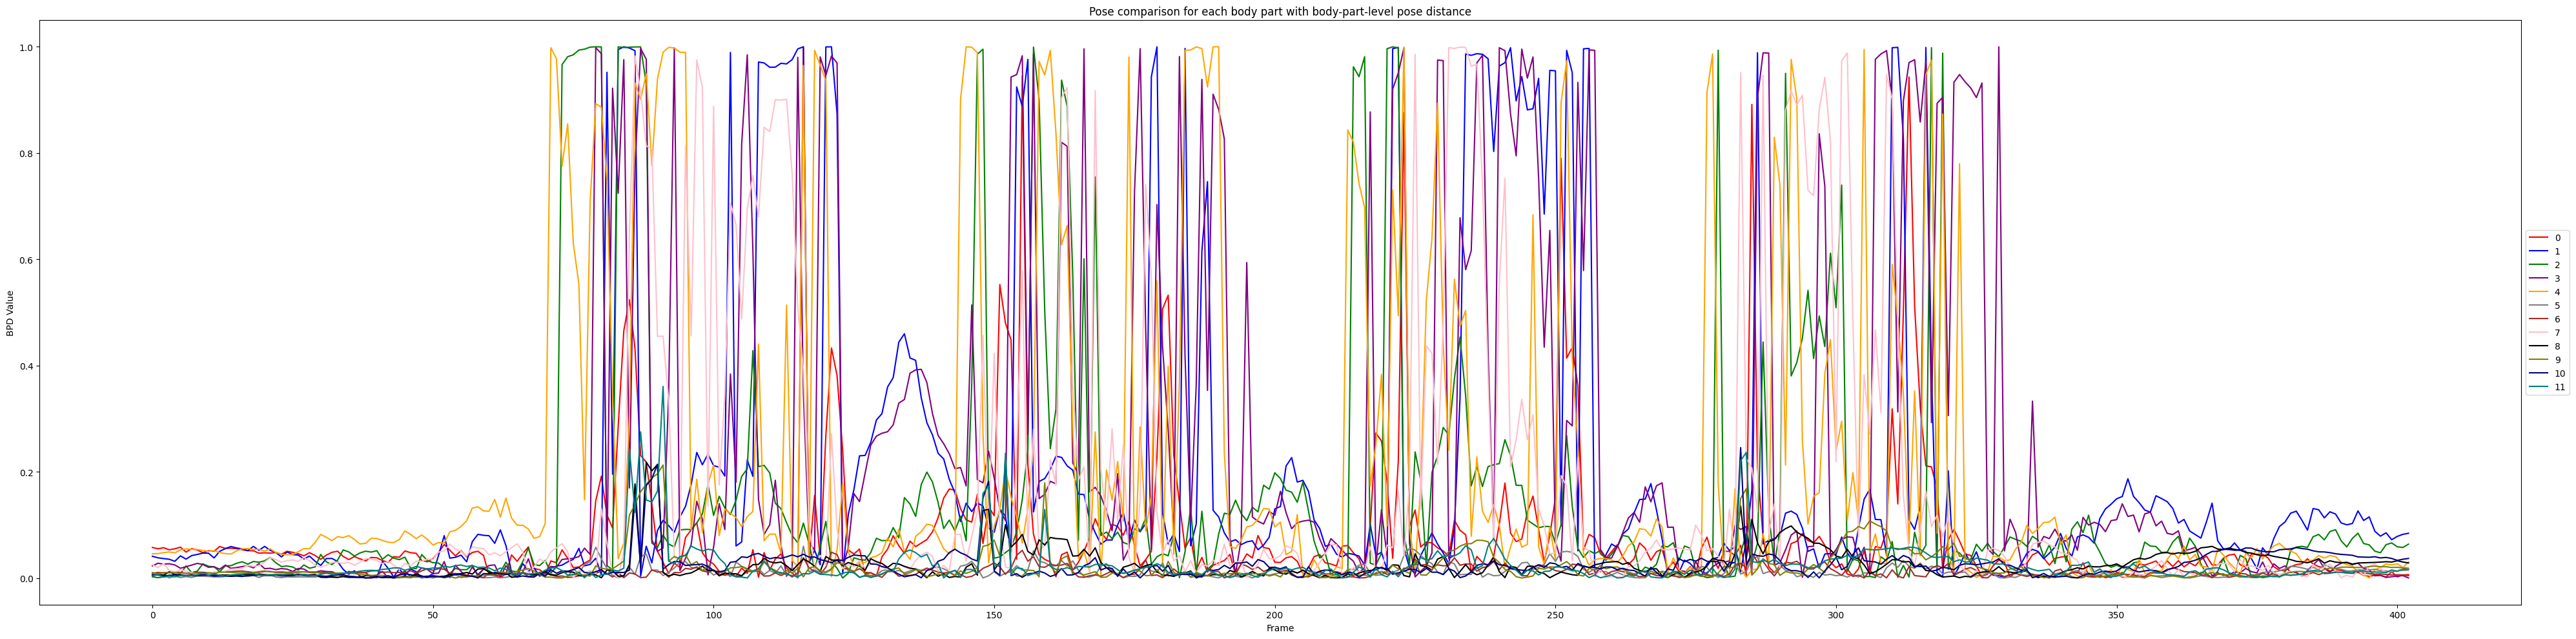

In [86]:
# Draw plot
import pandas as pd
import matplotlib.pyplot as plt

# create a sample dataframe
# data = pd.DataFrame({'col1': [1, 2, 3, 4, 5], 'col2': [2, 4, 6, 8, 10], 'col3': [3, 6, 9, 12, 15], 
#                      'col4': [4, 8, 12, 16, 20], 'col5': [5, 10, 15, 20, 25], 'col6': [6, 12, 18, 24, 30],
#                      'col7': [7, 14, 21, 28, 35], 'col8': [8, 16, 24, 32, 40], 'col9': [9, 18, 27, 36, 45], 
#                      'col10': [10, 20, 30, 40, 50], 'col11': [11, 22, 33, 44, 55], 'col12': [12, 24, 36, 48, 60]})

# plot the lines with different colors
plt.figure(figsize=(40,10))
plt.plot(saveBPD.index, saveBPD['0'], color='red', label='0')
plt.plot(saveBPD.index, saveBPD['1'], color='blue', label='1')
plt.plot(saveBPD.index, saveBPD['2'], color='green', label='2')
plt.plot(saveBPD.index, saveBPD['3'], color='purple', label='3')
plt.plot(saveBPD.index, saveBPD['4'], color='orange', label='4')
plt.plot(saveBPD.index, saveBPD['5'], color='grey', label='5')
plt.plot(saveBPD.index, saveBPD['6'], color='brown', label='6')
plt.plot(saveBPD.index, saveBPD['7'], color='pink', label='7')
plt.plot(saveBPD.index, saveBPD['8'], color='black', label='8')
plt.plot(saveBPD.index, saveBPD['9'], color='olive', label='9')
plt.plot(saveBPD.index, saveBPD['10'], color='navy', label='10')
plt.plot(saveBPD.index, saveBPD['11'], color='teal', label='11')

# set the title, x-axis label, y-axis label and legend
plt.title('Pose comparison for each body part with body-part-level pose distance')
plt.xlabel('Frame')
plt.ylabel('BPD Value')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# save as pdf file
plt.tight_layout()
plt.savefig("BPDtest.pdf")

# display the plot
plt.show()

In [64]:
data

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12
0,1,2,3,4,5,6,7,8,9,10,11,12
1,2,4,6,8,10,12,14,16,18,20,22,24
2,3,6,9,12,15,18,21,24,27,30,33,36
3,4,8,12,16,20,24,28,32,36,40,44,48
4,5,10,15,20,25,30,35,40,45,50,55,60


In [67]:
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
c = np.array([7, 8, 9])

saveBPD = np.array([])
saveBPD = np.append(saveBPD, a)
saveBPD

array([1., 2., 3.])

In [68]:
saveBPD = np.append(saveBPD, b)
saveBPD

array([1., 2., 3., 4., 5., 6.])

In [69]:
import pandas as pd
import numpy as np

# create an empty dataframe with the desired columns
df = pd.DataFrame(columns=['column_1', 'column_2', 'column_3'])

# loop to generate numpy arrays and append to the dataframe
for i in range(10):
    arr = np.random.rand(3)
    df = pd.concat([df, pd.DataFrame([arr], columns=df.columns)], ignore_index=True)

print(df)

   column_1  column_2  column_3
0  0.443061  0.310702  0.425159
1  0.809646  0.980979  0.312146
2  0.001951  0.830011  0.860644
3  0.199940  0.530914  0.121802
4  0.869159  0.615085  0.893276
5  0.485589  0.694791  0.437492
6  0.832801  0.254332  0.608751
7  0.086024  0.623217  0.902156
8  0.015526  0.682199  0.103819
9  0.649636  0.973024  0.737212


In [70]:
df

,column_1,column_2,column_3
0,0.443061,0.310702,0.425159
1,0.809646,0.980979,0.312146
2,0.001951,0.830011,0.860644
3,0.199940,0.530914,0.121802
4,0.869159,0.615085,0.893276
5,0.485589,0.694791,0.437492
6,0.832801,0.254332,0.608751
7,0.086024,0.623217,0.902156
8,0.015526,0.682199,0.103819
9,0.649636,0.973024,0.737212


In [72]:
df = pd.DataFrame(columns=[str(i) for i in range(12)])
df

,0,1,2,3,4,5,6,7,8,9,10,11
